<a href="https://colab.research.google.com/github/feli1984/adaptacionUpliftRedesneuronales/blob/main/TESIS_Data_B2C_PRUEBA_DE_ENFOQUES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Seminario 2 - Hito 2 - Data B2C - PRUEBA DE ENFOQUES

# 1.- Carga de librerías

In [ ]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift catboost pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-uplift xgboost==1.0.2 category_encoders==2.1.0 -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 10.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklift.models import ClassTransformation
from xgboost import XGBClassifier
from sklift.models import TwoModels
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklift.viz import plot_qini_curve , plot_uplift_by_percentile , plot_uplift_curve ,plot_treatment_balance_curve 
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import os
import random
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from keras.losses import mean_squared_error,binary_crossentropy
from tensorflow.keras.layers import Dense
from keras.layers.core import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
!pip install causalml
from causalml.inference.tf import DragonNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K




from sklift.metrics import (
     uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift, perfect_uplift_curve
 )


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.9/535.9 KB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.1 MB/s eta 0:00:00
  Created wheel for causalml: filename=causalml-0.13.0-cp38-cp38-linux_x86_64.whl size=1482421 sha256=4cad9b8e8fee47fd18e966881c2373d0c5f9c8ef966376f6e674a1dc42d30c11
  Stored in directory: /root/.cache/pip/wheels/69/88/0f/dacafa2cf04c6eeea7172fb8f4d41b82330f5ec9edf807d167
Successfully built cau

In [ ]:
# Cargamos las librerias para poder hacer el sobremuestreo de la data con SMOTE y limpiando con ENN
# from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# 2.- Cargamos datos

In [ ]:
 df = pd.read_csv("/content/dataframe.csv")
 

In [ ]:
##clase utilidades, y configuraciones iniciales
class utils:
  def __init__(self , dataset):
    self.dataset = dataset
    self.balance( self.dataset )
    self.alpha=0.05
    self.optimizer="rmsprop"
    self.reg = 0.01
    self.batch_size = 96
    self.epochs = 45
    self.input_dim = 29
    self.shape0 = (29,)
    self.shape1 = 1
    self.test_size =0.1
    self.ratio_balance='auto'
    self.set_transformed_outcome( self.dataset )
  ## es requerido q el total de observaciones de T sea igual en 1 y en 0
  def balance(self , dataset   ):
    self.dataset = dataset
    qty=0
    if( len(self.dataset[ self.dataset['group'] ==1 ]) > len(self.dataset[ self.dataset['group'] ==0 ]) ):
      delete_in_group = 1
      qty = len(self.dataset[ self.dataset['group'] ==1 ]) - len(self.dataset[ self.dataset['group'] ==0 ])
    elif( len(self.dataset[ self.dataset['group'] == 0 ]) > len(self.dataset[ self.dataset['group'] ==1 ]) ):
      delete_in_group = 0
      qty = len(self.dataset[ self.dataset['group'] ==0 ]) - len(self.dataset[ self.dataset['group'] ==1 ])
    else:
      delete_in_group = -1
    if( delete_in_group!=-1 ):
      set_to_join_1 = self.dataset[ self.dataset['group'] != delete_in_group  ]
      set_to_join_2 = self.dataset[ self.dataset['group'] == delete_in_group  ]
      set_to_join_2_0 = set_to_join_2[ set_to_join_2['buy_campaing'] == 0  ]
      set_to_join_2_1 = set_to_join_2[ set_to_join_2['buy_campaing'] == 1  ]

      set_to_delete = set_to_join_2_0.iloc[0:len(set_to_join_2_0)-qty,:]

      df = pd.DataFrame(data=set_to_delete)
      self.dataset = pd.concat([set_to_join_1, set_to_delete, set_to_join_2_1])
      return self.dataset
  
  def _replaceitem( self, x):
    if( x >= 0.5 ):
      return 1
    return 0

  def clean_list(  self,list  ):
    new_list = []
    for index_ in range(len(list)):
      j = list[index_]
      new_list.append( (j[0]) )
    return new_list
      

  #aplicamos la transformacion de clases
  def set_transformed_outcome( self , dataset_  ):
    self.dataset = dataset_
    self.dataset["z"] = 0;
    self.dataset.loc[ (self.dataset['buy_campaing'] == 1) & (self.dataset['group'] == 1) , 'z' ] = 2
    self.dataset.loc[ (self.dataset['buy_campaing'] == 1) & (self.dataset['group'] == 0) , 'z' ] = -2
    return self.dataset

  #esta red tiene un estructura similar a la que se implementara en la red siamesa, el unico proposito de esta es analizar los metodos de balanceo
  def build_rn( self, optimizer = '' , dropout_rate=0.0  , activation = "relu" , neurons= 15):
    if( optimizer ==""):
      optimizer = self.optimizer    
    classifier = Sequential()
    classifier.add(Dense( neurons , activation = activation, input_dim = utils.input_dim  , input_shape=utils.shape0 , name="layer1") )
    classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units = 10, activation = "relu", name="layer2"))
    classifier.add(Dropout(dropout_rate))
    classifier.add(Dense(units = 1, kernel_initializer = "uniform",  activation = "sigmoid", name="layer3"))

    classifier.compile( optimizer= optimizer, loss="binary_crossentropy" , metrics=["accuracy"],
                        )
    
    return classifier


  ## calcular los pesos
  def get_weights( self, y_train ):
    weights_ = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    weights_ = { 0 : weights_[0] , 1:weights_[1]  }
    return weights_

  ##para generar los pares
  def make_pairs(self, X_test , z ):
    input1 = X_test.copy()
    input2 = X_test.copy()

    input1 = np.hstack(( input1, np.zeros(( input1.shape[0], 1), dtype= input1.dtype)))
    input2 = np.hstack(( input2, np.zeros(( input2.shape[0], 1), dtype= input2.dtype)))
    input2[:,-1] = 1 #input 0 con T = 1 
    input1[:,-1] = 0 #input 1 con T = 0 

    return [input1, input2], z

  
    



utils = utils( df )
dataset = utils.balance( df )
dataset = utils.set_transformed_outcome( dataset )
seed_value= 333
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
dataset.shape

(4664, 30)

In [ ]:
#nos aseguramos que no existan datos nulos
dataset.dtypes
display(dataset.isnull().values.any())

False

In [ ]:
dataset["buy_campaing"].mean()*100

3.2804459691252146

In [ ]:
len(dataset[ dataset['group'] ==1 ])# 1 = Mk o Tratamiento

2332

In [ ]:
len(dataset[ dataset['group'] ==0 ])# 0 = Control 

2332

# 3.- Separación de datos Objetivo, tratamiento

In [ ]:
dataset_aux = dataset.copy()
train_dataset= dataset_aux.sample( frac = 1-utils.test_size) # saca el 90% de datos aleatorios 
test_dataset = dataset_aux.drop( train_dataset.index )# deja aquellos que no fueron sampleados

In [ ]:
train_dataset.shape

(4198, 30)

In [ ]:
smot =  SMOTEENN(sampling_strategy=0.6) 
over_x = train_dataset # data set balanceado 
over_y = over_x['buy_campaing'] # columna de compras 

del( over_x['buy_campaing']  )
del( over_x['z']  )

over_x_res, over_y_res = smot.fit_resample(over_x, over_y)
X_train = pd.DataFrame(over_x_res, columns=over_x.columns)
final_data = pd.DataFrame(data=X_train)
final_data = final_data.assign( buy_campaing = over_y_res)
final_data

# Balanceo
dataset_final = utils.balance( final_data )
dataset_final = utils.set_transformed_outcome( dataset_final )
dataset_final

# 4.- Pruebas de enfoques

## 4.1.- Enfoque un modelo

In [ ]:
dataOnemodelos = dataset_final.copy()
dataOnemodelos = dataOnemodelos.drop('z', axis =1)              
target  = dataOnemodelos['buy_campaing'].values
treatment  = dataOnemodelos['group'].values

In [ ]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
   dataOnemodelos, target, treatment, test_size=0.5 , stratify = target #random_state=42
)

In [ ]:
##Enfoque un modelo
sm = SoloModel(CatBoostClassifier(iterations=1000,verbose=50, random_state=777))
sm = sm.fit(X_tr, y_tr,treat_tr, estimator_fit_params={'plot': True})
uplift_sm = sm.predict(X_val)

In [ ]:
ATE = 0
ATE = uplift_sm.mean()


In [ ]:
#Desviación Estandard
sd = np.std(uplift_sm)
sd

0.001473195849592179

ate: 0.0003
Uplift90% : 0.38946
qini_auc_score : 0.17342
uplift_auc_score : 0.16012


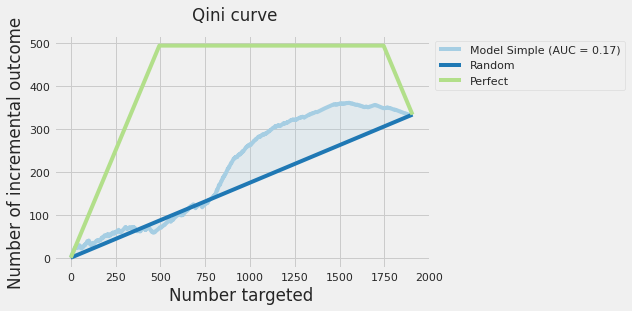

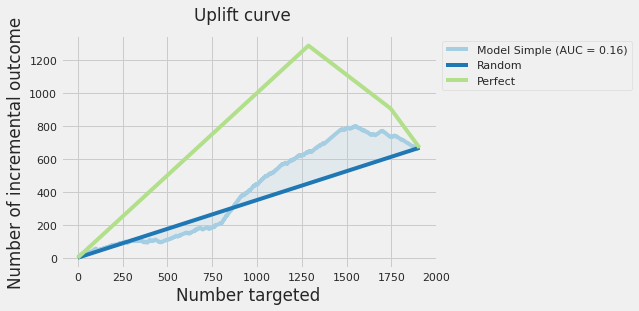

In [ ]:
#Calcule el aumento en las primeras k observaciones mediante el aumento de la muestra total.
#Donde K es el tamaño de la muestra 

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.9)

# Area Under Qini Curve
sm_qini_auc_score = qini_auc_score(y_true=y_val, uplift=uplift_sm, treatment=treat_val)

# Area Under Uplift Curve
sm_uplift_auc_score = uplift_auc_score(y_true=y_val, uplift=uplift_sm, treatment=treat_val)


qini_disp = plot_qini_curve( y_val, uplift_sm, treat_val, perfect=True, name='Model Simple');
qini_disp.figure_.suptitle("Qini curve");


uplift_disp = plot_uplift_curve(y_val, uplift_sm, treat_val, perfect=True, name='Model Simple');
uplift_disp.figure_.suptitle("Uplift curve");



#obtener probabilidades condicionales (predicciones) de realizar la acción objetivo
sm_trmnt_preds = sm.trmnt_preds_

#Y probabilidades condicionales (predicciones) de realizar la acción objetivo
# sin interacción para cada objeto
sm_ctrl_preds = sm.ctrl_preds_


print(f'ate: {ATE:.4f}')
print(f'Uplift90% : {sm_score:.5f}')
print(f'qini_auc_score : {sm_qini_auc_score:.5f}')
print(f'uplift_auc_score : {sm_uplift_auc_score:.5f}')


## 4.2.- Enfoque 2 modelos


In [ ]:
from sklift.models import ClassTransformation
from xgboost import XGBClassifier
from sklift.models import TwoModels
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder

In [ ]:
data2modelos = dataset_final.copy()
data2modelos = data2modelos.drop('z', axis =1)              
target  = data2modelos['buy_campaing'].values
treatment  = data2modelos['group'].values

In [ ]:
estimator_trmnt = CatBoostClassifier(iterations=1500,silent=True, thread_count=3, random_state=42)
estimator_ctrl = CatBoostClassifier(iterations=1500,silent=True, thread_count=3, random_state=42)

In [ ]:
cat_features=list(range(len(data2modelos.columns)))

In [ ]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
   data2modelos, target, treatment, test_size=0.5 , stratify = target #random_state=42
)


In [ ]:
# define approach
tm_ctrl = TwoModels(
    estimator_trmnt=estimator_trmnt,
    estimator_ctrl=estimator_ctrl,
    method='ddr_control'
)

tm_ctrl = tm_ctrl.fit(X_tr, y_tr, treat_tr, estimator_trmnt_fit_params={'cat_features': cat_features},
                      estimator_ctrl_fit_params={'cat_features': cat_features})

In [ ]:
uplift_tm_ctrl = tm_ctrl.predict(X_val) 


In [ ]:
ATE = uplift_tm_ctrl.mean()

uplift@90%: 0.4221
two_qini_auc_score: 0.3045
two_uplift_auc_score: 0.4832


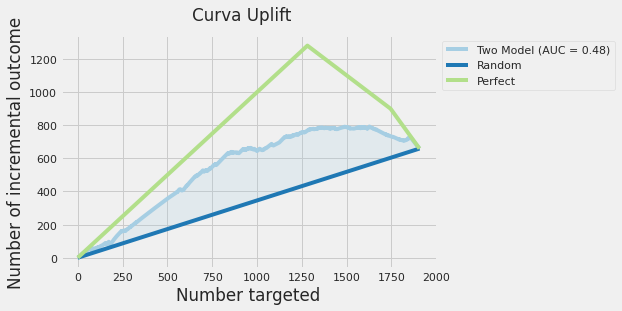

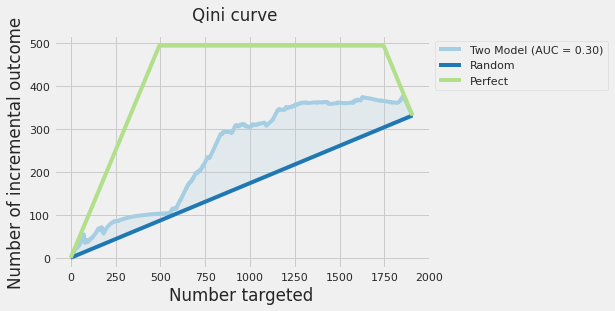

In [ ]:
two_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.9)

two_qini_auc_score = qini_auc_score(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val)

two_uplift_auc_score = uplift_auc_score(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val)

#obtener probabilidades condicionales (predicciones) de realizar la acción objetivo
two_trmnt_preds = tm_ctrl.trmnt_preds_

#Y probabilidades condicionales (predicciones) de realizar la acción objetivo
# sin interacción para cada objeto
two_ctrl_preds = tm_ctrl.ctrl_preds_


uplift_disptwo = plot_uplift_curve(y_val, uplift_tm_ctrl, treat_val, perfect=True, name='Two Model');
uplift_disptwo.figure_.suptitle("Curva Uplift");

print(f'uplift@90%: {two_score:.4f}')
print(f'two_qini_auc_score: {two_qini_auc_score:.4f}')
print(f'two_uplift_auc_score: {two_uplift_auc_score:.4f}')

qini_disptwo = plot_qini_curve( y_val, uplift_tm_ctrl, treat_val, perfect=True, name='Two Model');
qini_disptwo.figure_.suptitle("Qini curve");


#plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

## 4.3 Enfoque transformacion de clase

In [ ]:
dataCmodelos = dataset_final.copy()
dataCmodelos = dataCmodelos.drop('z', axis =1)              
target  = dataCmodelos['buy_campaing'].values
treatment  = dataCmodelos['group'].values

In [ ]:
X_tr, X_val, y_tr, y_val, treat_tr, treat_val = train_test_split(
   dataCmodelos, target, treatment, test_size=0.5 , stratify = target #random_state=42
)

In [ ]:
cat_features=list(range(len(dataCmodelos.columns)))

In [ ]:
from sklift.models import ClassTransformation
from xgboost import XGBClassifier
from sklift.models import TwoModels
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklift.viz import plot_qini_curve , plot_uplift_by_percentile , plot_uplift_curve ,plot_treatment_balance_curve 

from sklift.metrics import (
     uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift, perfect_uplift_curve
 )


encoder = CatBoostEncoder()
estimator = XGBClassifier(max_depth=2, random_state=42)
ct = ClassTransformation(estimator=estimator)

my_pipeline = Pipeline([
    ('encoder', encoder),
    ('model', ct)
])

my_pipeline = my_pipeline.fit(
    X=X_tr,
    y=y_tr,
    model__treatment=treat_tr
) 

In [ ]:
uplift_predictions = my_pipeline.predict(X_val)

In [ ]:
ATE = uplift_predictions.mean()

uplift_90%:  0.49619
qini_auc_score : 0.13929
uplift_auc_score : 0.71689


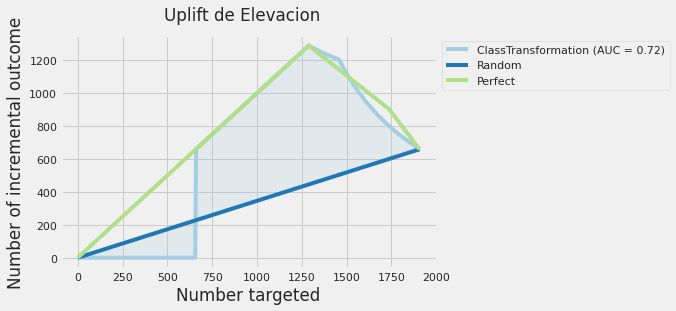

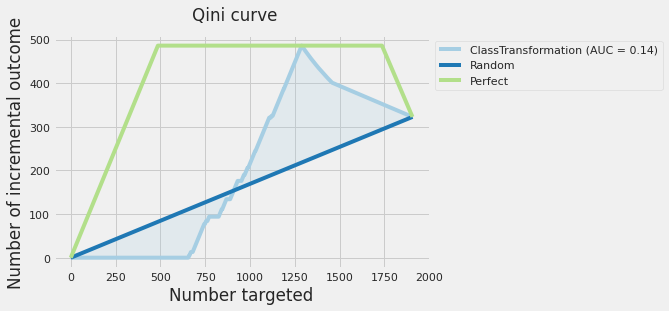

In [ ]:
uplift_90 = uplift_at_k(y_val, uplift_predictions, treat_val, strategy='by_group', k=0.9)

# Area Under Uplift Curve
sm_uplift_auc_score = uplift_auc_score(y_true=y_val, uplift=uplift_predictions, treatment=treat_val)

upliftElevacion = plot_uplift_curve(y_val, uplift_predictions, treat_val, random=True, perfect=True, ax=None, name='ClassTransformation')
upliftElevacion.figure_.suptitle("Uplift de Elevacion")

# Area Under Qini Curve
sm_qini_auc_score = qini_auc_score(y_true=y_val, uplift=uplift_predictions, treatment=treat_val)

qini_disp = plot_qini_curve( y_val, uplift_predictions, treat_val, perfect=True, name='ClassTransformation');
qini_disp.figure_.suptitle("Qini curve")

#models_results['approach'].append('ClassTransformation')
#models_results['uplift@30%'].append(uplift_90)

#Desviación Estandard 
sd = np.std(uplift_predictions)


print(f'uplift_90%:  {uplift_90:.5f}')
print(f'qini_auc_score : {sm_qini_auc_score:.5f}')
print(f'uplift_auc_score : {sm_uplift_auc_score:.5f}')


